In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My\ Drive/Colab\ Notebooks/MIMO

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/MIMO


In [4]:
from __future__ import print_function
import matplotlib.pyplot as plt
import scipy.io as sio
from torchsummary import summary

import os

import warnings
warnings.filterwarnings('ignore')

from include import *
from PIL import Image
import PIL

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable
import pdb

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    #os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 1


## Utilities

In [2]:
from numpy.linalg import norm,solve,inv

def getH(M):
    return np.conjugate(M).T

def NMSE(H, H_cap):
    diff = H_cap - H
    return (norm(diff)**2/norm(H)**2)

def denoise(img_noisy_var,k=8,numit = 1800,rn = 0.0,find_best=True,upsample_first = True):
    num_channels = [k]*5
    net = decodernw(output_depth,num_channels_up=num_channels,upsample_first=upsample_first,need_sigmoid=False).type(dtype)
    #summary(net, (k,2,2))
    #pdb.set_trace()
    mse_n, mse_t, ni, net = fit( num_channels=num_channels,
                        reg_noise_std=rn,
                        num_iter=numit,
                        img_noisy_var=img_noisy_var,
                        net=net,
                        img_clean_var=img_clean_var,
                        find_best=find_best
                        )
    out_img_np = net( ni.type(dtype) ).data.cpu().numpy()[0]
    return out_img_np, mse_t

In [23]:
H_org = sio.loadmat("H_64x64x64_EPA.mat")

interference10 = sio.loadmat("interference10.mat")
int10_extracted = interference10['interference']

interference05 = sio.loadmat("interference05.mat")
int05_extracted = interference05['interference']

array = ['noisy_0dB', 'noisy_5dB', 'noisy_10dB', 'noisy_15dB', 'noisy_20dB']
length = 20
snrs = [0,5,10,15,20];
Nsub = 64
Nr = 64

all_int = []
all_int.append(np.zeros(int10_extracted.shape))
all_int.append(int05_extracted)
all_int.append(int10_extracted)

In [40]:
int_10_extracted = sio.loadmat("interference_10.mat")['interference']
int_15_extracted = sio.loadmat("interference_15.mat")['interference']
int_20_extracted = sio.loadmat("interference_20.mat")['interference']
all_int1 = [int_10_extracted, int_15_extracted, int_20_extracted]

In [44]:
vect_noise = np.zeros((64,64,64,len(array),length),dtype=complex)
Niter = {8:4000, 16:1970, 32:1800, 64:1000}
titles = ["Deep Channel Est SIR 10dB", "Deep Channel Est SIR 15dB", "Deep Channel Est SIR 20dB"]
chk = 0
dd_errors = {}
Ns = 16

for int_extracted in all_int1:
    print(titles[chk])
    dd_errors[titles[chk]] = np.zeros((length, len(array)))
    for k in range(length): 
        print(k,end= ' ')
        K = k
        H_extracted = H_org['noiseless']
        H_clean = H_extracted[:,0,:,K].reshape(64*64,1)
        img_np_real = np.real(H_extracted[:,:,:,k])
        img_np_imag = np.imag(H_extracted[:,:,:,k])
        img_np = np.zeros((128,64,64))
        img_np[0:64,:,:,] = np.transpose(img_np_real,(2,0,1))
        img_np[64:128,:,:] = np.transpose(img_np_imag,(2,0,1))
        img_clean_var = np_to_var(img_np).type(dtype)
        output_depth = img_np.shape[0] 
        # print("Image size: ", img_np.shape)
        i = 0
        for noise_level in array:
            print(noise_level, end=' ')
            H_extracted = H_org[noise_level]
            img_noisy_np_real = np.real(H_extracted[:,:,:,0,k]) + int_extracted[:,:,:,k]
            img_noisy_np_imag = np.imag(H_extracted[:,:,:,0,k]) + int_extracted[:,:,:,k]
            img_noisy_np = np.zeros((128,64,64))
            img_noisy_np[0:64,:,:] = np.transpose(img_noisy_np_real,(2,0,1))
            img_noisy_np[64:128,:,:] = np.transpose(img_noisy_np_imag,(2,0,1))
            img_noisy_var = np_to_var(img_noisy_np).type(dtype)
            
            out_img_np, mse_t = denoise(img_noisy_var,k=Ns,numit = Niter[Ns],rn = 0.0)
            img_np_real_allcol = np.transpose(out_img_np[0:64,:,:],(1,2,0)) 
            img_np_imag_allcol = np.transpose(out_img_np[64:128,:,:],(1,2,0))
            img_np_real = np.tile(np.reshape(img_np_real_allcol[:,0,:],(64,1,64)),(1,64,1))
            img_np_imag = np.tile(np.reshape(img_np_imag_allcol[:,0,:],(64,1,64)),(1,64,1))
            vect_noise[:,:,:,i,k] = np.array(img_np_real+1j*img_np_imag,dtype=complex)
            dd_errors[titles[chk]][k][i] = NMSE(H_clean ,vect_noise[:,0,:,i,K].reshape(64*64,1))
            i = i+1
        print('')
    chk += 1
    
# dd_store = {}
# for k in dd_errors:
#     dd_store[k] = dd_errors[k] 
sio.savemat('./MIMO_int1_dd_errors.mat', dd_errors)

Deep Channel Est SIR 10dB
0 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
1 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
2 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
3 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
4 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
5 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
6 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
7 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
8 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
9 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
10 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
11 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
12 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
13 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
14 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
15 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
16 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
17 noisy_0dB no

In [41]:
ls_errors = np.zeros((length, len(array)))
mmse_errors = np.zeros((length, len(array)))
mmse_true_errors = np.zeros((length, len(array)))

Rhh = np.zeros((Nsub*Nr,Nsub*Nr))
for i in range(length):
    tmp = H_org['noiseless'][:,0,:,i].reshape(64*64,1)
    Rhh = Rhh + (1/length)*np.matmul(tmp, getH(tmp));

for k in range(length): 
    print(k, end=' ')
    H = H_org['noiseless'][:,0,:,k].reshape(64*64,1)
    chn_norm_factor = norm(H)/((Nsub*Nr)**0.5); 
    i = 0
    for noise_level in array:
        print(noise_level, end=' ')

        H_ls = H_org[noise_level][:,0,:,0,k].reshape(64*64,1) + int_10_extracted[:,0,:,k].reshape(64*64,1)

        tmp = (chn_norm_factor/(10**(snrs[i]/10)))*np.eye(64*64)

        mse_ls = NMSE(H, H_ls)

        H_mmse = np.matmul(Rhh, solve(Rhh+tmp, H_ls))
        mse_mmse = NMSE(H, H_mmse)

        Rhh_true = np.matmul( H, getH(H) )
        H_mmse_true = np.matmul(Rhh_true, solve(Rhh_true+tmp, H_ls))
        mse_mmse_true = NMSE(H,H_mmse_true)

        ls_errors[k][i] = mse_ls
        mmse_errors[k][i] = mse_mmse
        mmse_true_errors[k][i] = mse_mmse_true

        i = i+1
    print('')

est_errors = {}
est_errors['LS'] = ls_errors
est_errors['MMSE'] = mmse_errors
est_errors['Genie Aided MMSE'] = mmse_true_errors
sio.savemat('./MIMO_int1_errors.mat', est_errors)

0 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
1 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
2 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
3 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
4 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
5 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
6 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
7 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
8 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
9 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
10 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
11 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
12 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
13 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
14 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
15 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
16 noisy_0dB noisy_5dB noisy_10dB noisy_15dB noisy_20dB 
17 noisy_0dB noisy_5dB noisy_10dB noisy_1

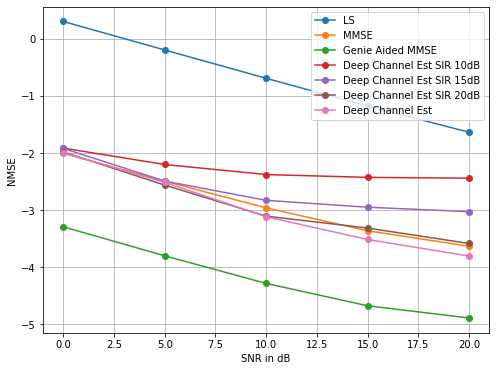

In [50]:
snrs = [0,5,10,15,20];
all_noises = sio.loadmat('./MIMO_int1_errors.mat')
dd_noises = sio.loadmat('./MIMO_int1_dd_errors.mat')
plt.figure(figsize=(8,6))
plt.xlabel("SNR in dB")
plt.ylabel("NMSE")
for k in list(all_noises.keys())[3:]:
    # if(k == "Genie Aided MMSE"): continue
    plt.plot(snrs, np.log10(np.mean(all_noises[k][:][:], axis=0)),'-o', label=k)
for k in list(dd_noises.keys())[3:]:
    plt.plot(snrs, np.log10(np.mean(dd_noises[k][:][:], axis=0)),'-o', label=k)
plt.legend()
plt.grid()
plt.show()

In [51]:
!ls

H_64x64x64_EPA.mat   interference_15.mat      MIMO_int1_errors.mat
include		     interference_20.mat      MIMO_int_dd_errors.mat
interference05.mat   MIMO_dd_errors.mat       MIMO_int_errors.mat
interference_10.mat  MIMO_errors.mat
interference10.mat   MIMO_int1_dd_errors.mat
